# Monte Carlo simulations using the `Optimizer` class and workflow using its `srad` and `plot_srad_optimization` methods 

The `prms_python` module's `Optimizer` class allows for modular methods of step-wise parameter optimization of PRMS consisting of three steps:
1. Solar radiation
2. Potential evapotranspiration
3. Streamflow (surface runoff, interflow, groundwater flow)

The default method of optimization, shown in this notebook, is simple monte carlo simulations done for a set of PRMS parameters that are pseudo-randomly modified. In this example we show how to run the monte carlo simulation  by modification on the degree day solar radiation parameters in PRMS, 

* `dday_slope` 
* `dday_intcp` 

These two parameters are used in a modified degree-day model `ddsolrad` a PRMS module that relates daily maximum temperature to the ratio of actual to potential daily solar radiation which is later used to estimate daily solar radiation. When using PRMS's ddsolrad module `dday_slope`, and `dday_intcp` are required for each month. The initial estimation of these parameters should be calculated using historical air temperature and solar radiation measurements if available as described in the [PRMS manual](http://pubs.usgs.gov/tm/6b7/). It is important to have the original parameter estimation as accurate as possible to reduce the numeer of monte carlo simulations required to get improved results. The pseudo-random sampling method that the `Optimizer.srad` method uses works by generating new parameter sets by random samping around the monthly parameter values that exist in the initial parameter set (see below). Additional sampling methods will be added in the future as well as different and sophisticated optimization techniques. 

In [1]:
import sys
sys.path.append('..')
from prms_python import Data, Optimizer, Parameters, util
from prms_python.optimizer import _resample_param as resample
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

## Example of 50 pseudo-random parameter sets created using the default method built into the `Optimizer.srad` method

This illustration shows the distribution of new parameter values around the initial values for each monthly parameter value for the degree day slope parameter. It also shows why it is important to have a good initial estimation of the parameters you are trying to optimize using the monte carlo method. 

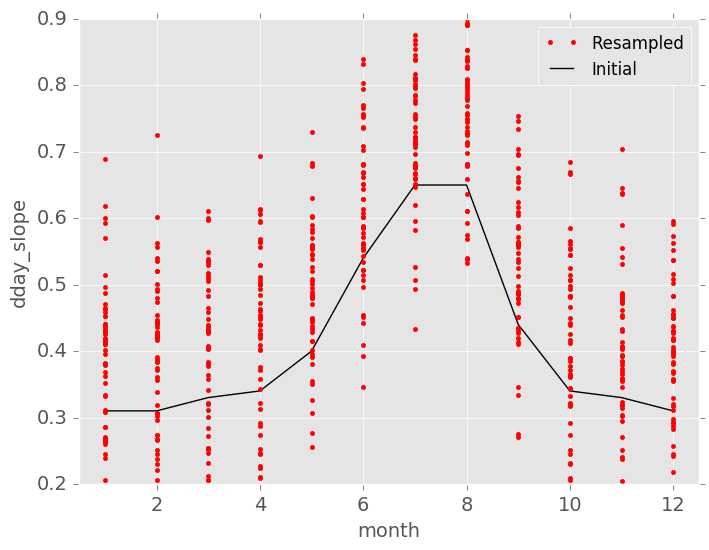

In [2]:
params = Parameters('../test/data/models/lbcd/parameters')

plt.figure(figsize=(8,6))
for i in range(50):
    plt.plot(np.arange(1,13), resample(params['dday_slope'], 0.2, 0.9), 'r.')
    if i == 0:
        plt.plot(np.arange(1,13), resample(params['dday_slope'], 0.2, 0.9), 'r.', label='Resampled')
        plt.plot(np.arange(1,13), params['dday_slope'], 'k', label = 'Initial')
plt.xlim(0.5,12.5)
plt.xlabel('month', fontsize=14)
plt.ylabel('dday_slope',fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend()
plt.show()

As you can see, the random sampling of the parameter above results in many new parameter sets which are mostly centered around the initial paraemter set. 

## An example workflow for using an `Optimizer` instance for solar radiation Monte Carlo simulations

In [3]:
# set file paths for input files and output directory as well as measured solar radiation csv
params = Parameters('../test/data/models/lbcd/parameters')
data = Data('../test/data/models/lbcd/data')
control = '../test/data/models/lbcd/control'
work_directory = '../test/results/'
# create an Optimizer instance with the paths, be sure to always give it a title (required)
optr = Optimizer(params, data, control, work_directory, title='testing_srad')

## The measured solar radiation file 

The measured solar radiation file is needed for comparing the simulated results to itself to determine model accuracy. It should be a csv file without a header, the first column should contain a date in the form YYYY-MM-DD and the second column contains the measured solar radiation data (typically in langleys for PRMS comparison). 

Measured solar radiation data should have a geoographic location that corrpesonds to an HRU that the user supplies in order to compare results (see `srad_hru` below). This information is needed in order to run the `srad` method (below) see some example lines from a valid measured solar radiation file in the cell below.  Other date formats may work as well but were not tested, the function used to read the file is [Pandas.Series.from_csv](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.from_csv.html) with the `parse_dates=True` keyword argument which tries to parse the index (first column) as date-times. 

In the future we would like to have more robust options for measured-simulated comparisons, for example to compare simulates and measured results from multiple HRU's or area-weighted averages. For most watershed applications a single comparison is often sufficient.

In [4]:
srad_hru = 2490
measrd = '../test/data/fake_measured_swrad_lbcd.csv'
# top 5 lines of a valid measured solar radiation file
with open(measrd) as fh:
    for i,line in enumerate(fh):
        print(line.strip())
        if i == 4: break

1937-10-01,447.752204422
1937-10-02,441.216580147
1937-10-03,410.682144625
1937-10-04,176.349945467
1937-10-05,126.152799887


In [5]:
# run the solar radiation monte carlo simulations (default optimization method) for a total of 4 simulations
optr.srad(measrd, srad_hru, n_sims=4)
util.delete_out_files(work_directory, 'prms_ic.out') #delete all PRMS output files for initial conditions

['../test/results/intcp:-27.098_slope:0.464', '../test/results/intcp:-24.997_slope:0.557', '../test/results/intcp:-9.533_slope:0.597', '../test/results/intcp:-13.092_slope:0.374']
--------------------------------------------------------------------------------
Output information sent to ../test/results/testing_srad_swrad_opt23.json



_**Side note**_, the `srad` method saves metadata to a [json file](http://json.org/) for each succeesful execution, basic information is printed when to the console as well including the location of the json that was just created from the current optimization.  Here is the contents of a Monte Carlo optimization simulation output json that was initiated the same way as the one shown above:

```python
{
    "end_time": "2016-11-10 16:09:00",
    "measured_swrad": "../test/data/fake_measured_swrad_lbcd.csv",
    "n_sims": 4,
    "optimization_description": null,
    "optimization_title": "testing_srad",
    "original_params": "../test/data/models/lbcd/parameters",
    "sim_dirs": [
        "../test/results/intcp:-7.982_slope:0.568",
        "../test/results/intcp:-21.495_slope:0.468",
        "../test/results/intcp:-18.289_slope:0.520",
        "../test/results/intcp:-27.535_slope:0.429"
    ],
    "stage": "swrad",
    "start_time": "2016-11-10 16:09:00",
    "swrad_hru_id": 2490
}
```

This information is useful for the user and the PRMS-Python framework, and json is a natural fit because the syntax of json is pretty much identical to the Python dictionary data structure. 

### output file naming system
Also, each `srad` optimization simulation is conducted in it's own seprate directory, that way you can revisit these if they are giving good results. Each simulation will follow the rules that are set from the initial control file given to the `Optimization` instance. The name of each simulation is used for future referencing and has the following format 

```bash
intcp[value of mean of dday_intcp]:_slope[value of mean of dday_slope]
```
for example:

```bash
intcp:-21.495_slope:0.468
```
This naming scheme serves a couple purposes: 1) the directory can be used keep track of which parameter modifications were conducted on the parameter file; 2) the name is used in the basic plots from the results as well more sophisticated result reporting from an `OptimizationResult` object (not shown in this notebook); 3) the likelyhood of having the mean of multiple altered parameters (dday_slope and dday_intcp in this case) to 3 decimals is extremely small, therefore each name is unique. However the uniqueness is not an issue and is not necessary as each json metadata file maps to the set of output (simulation) directories that it corresponded with, and there is never a case where a metadata (json) file name will be duplicated due to a built in renaming system. If there ever was a duplicated parameter set within a single Optimizer instance, the first established simulation directory would simply be overwritten.

## Quick and basic visualizations of current optimization solar radiation results

### correlation between measured and simulated
* plots a one to one line and scatterplots of simulated versus measured for each monte carlo simulation result
* plots coefficient of determination $R^2$ for each simulation against the measured data

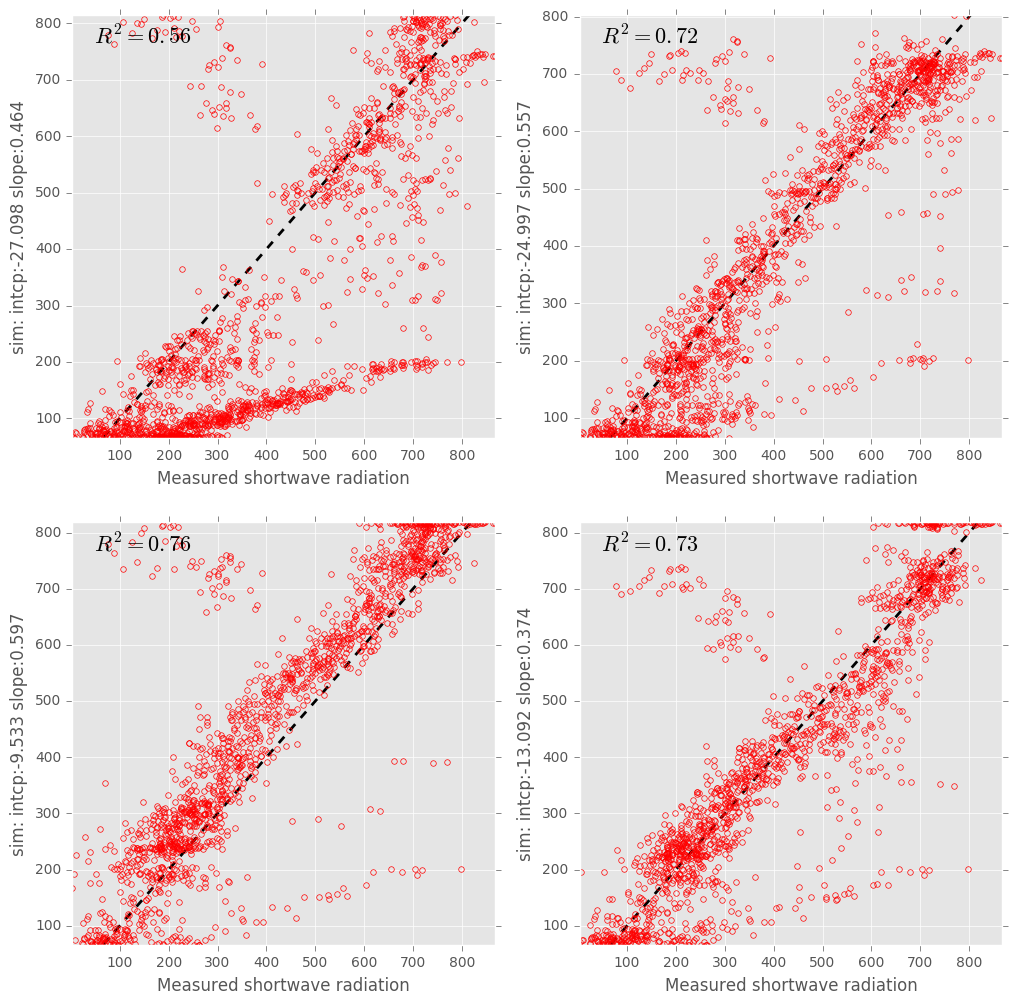

In [6]:
optr.plot_srad_optimization(method='correlation')

### time series of daily measured, initially simulated and new simulated solar radiation (default method)

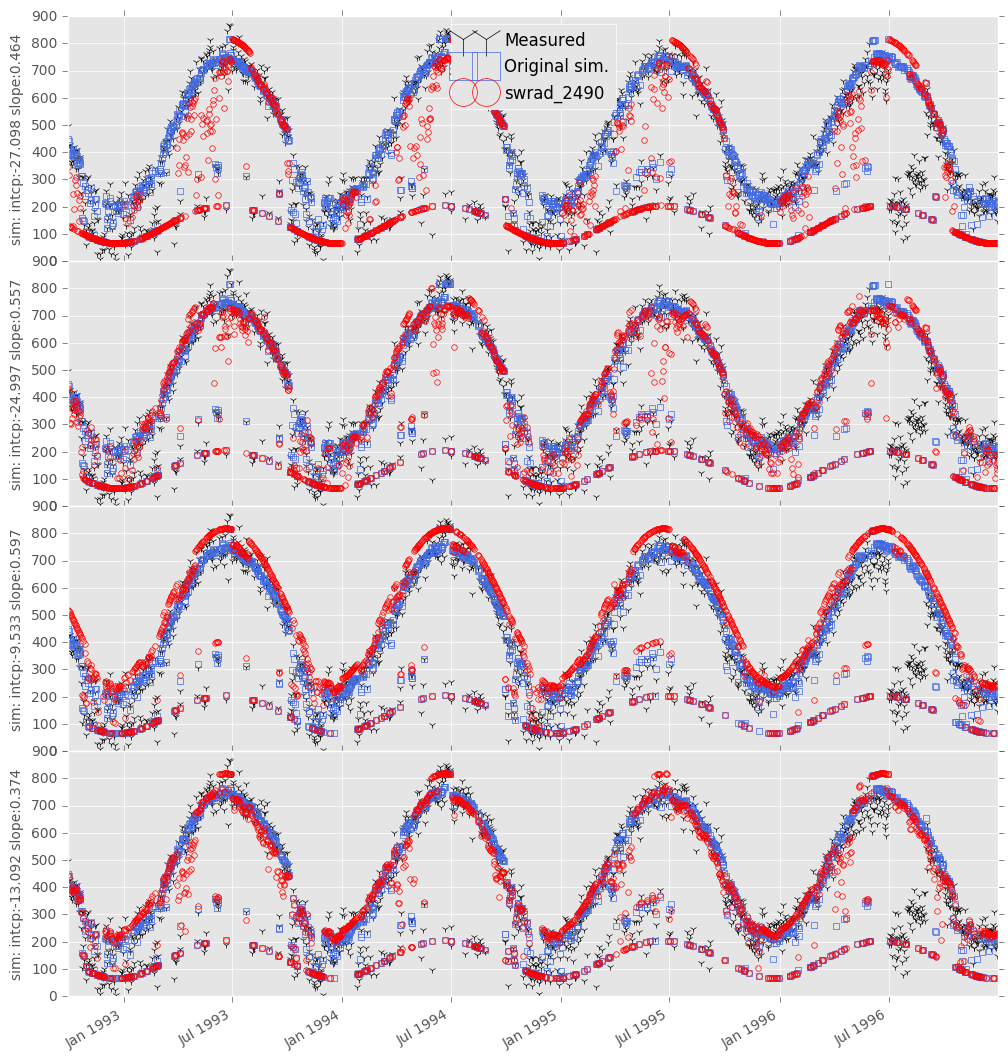

In [7]:
optr.plot_srad_optimization()

### monthly means

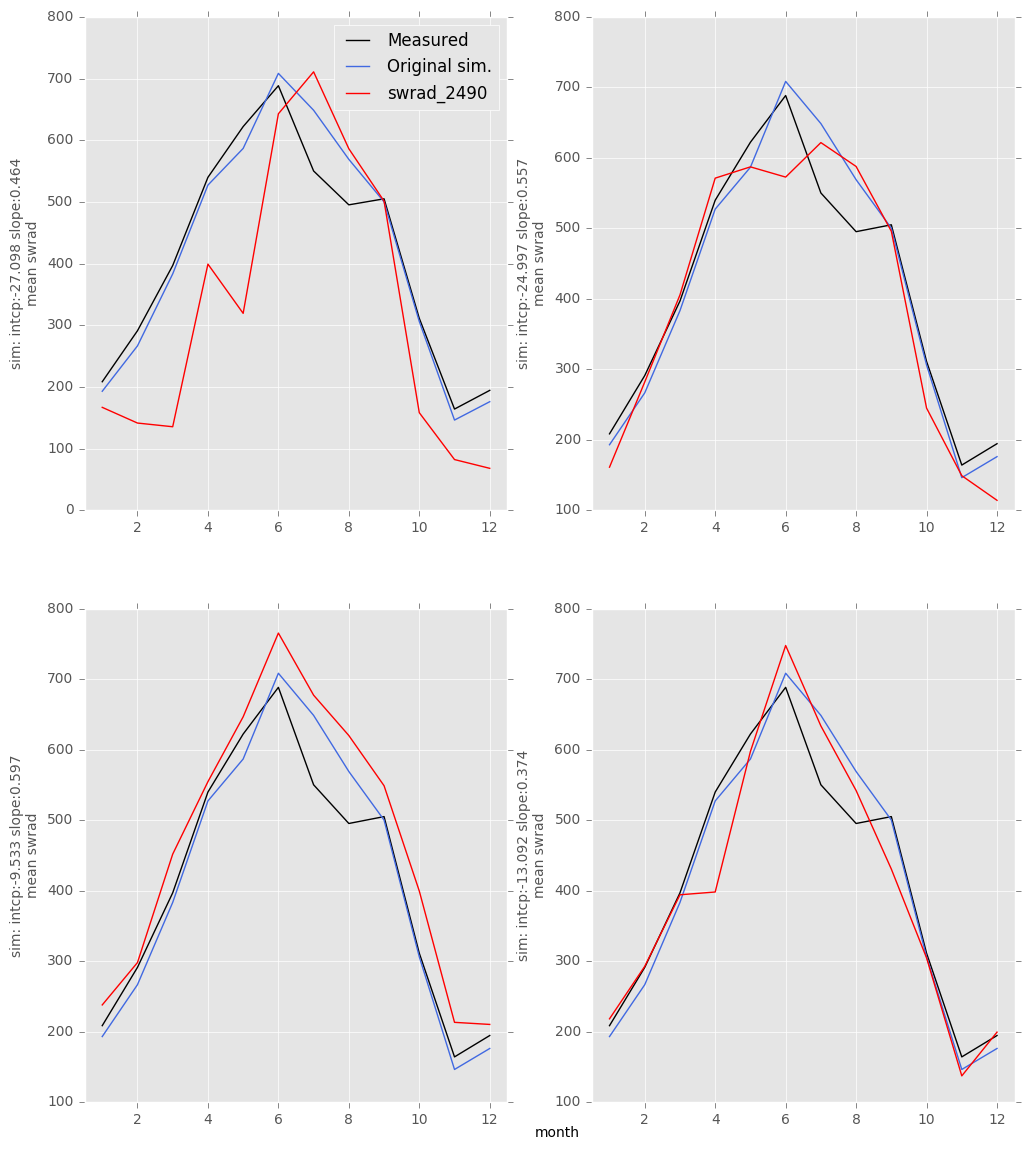

In [8]:
optr.plot_srad_optimization(freq='monthly')

## Get figure object using keyword `return_fig` and save image to disk
### only plot measured and simulated data (not original simulation) 

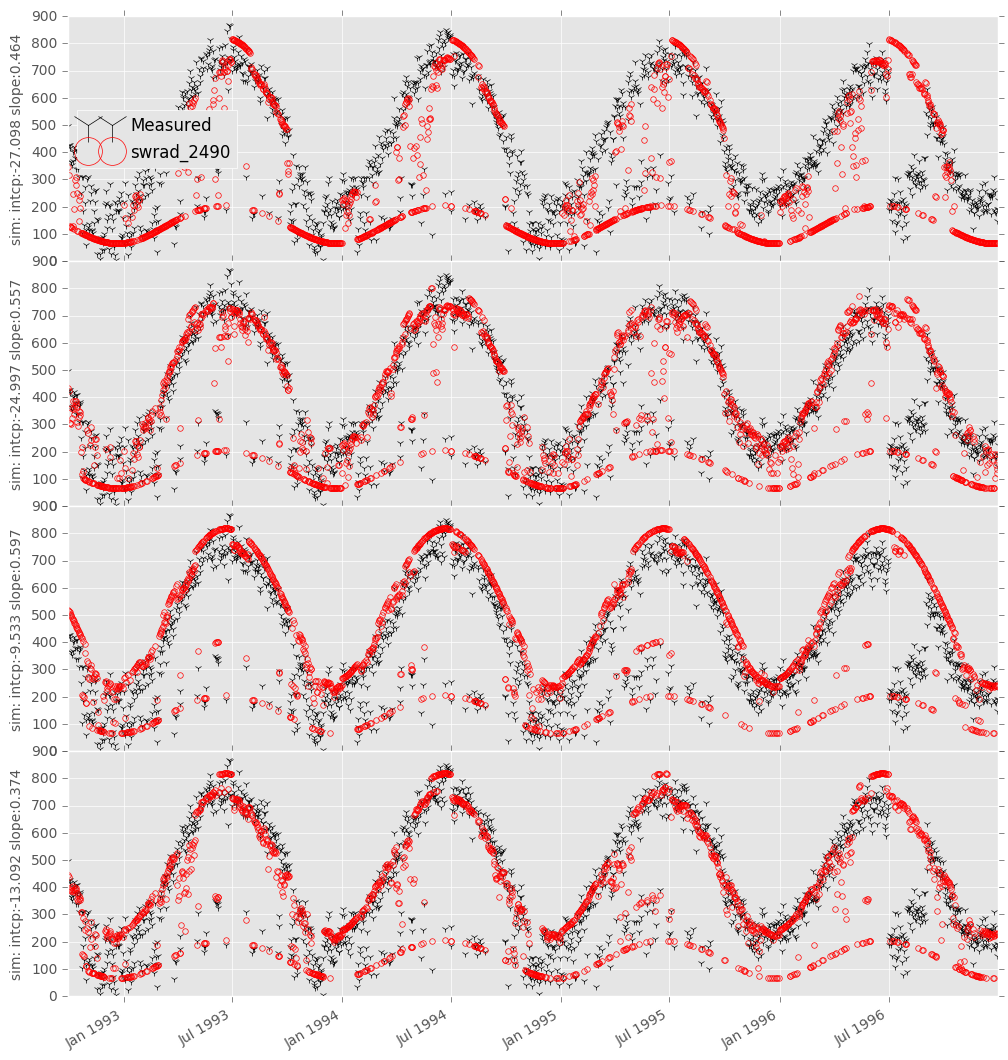

In [9]:
#you can change the plot_vars keyword option to show both measured and original simulated solar radiation
# or one or the other alongside the optimization simulations using: 'both', 'meas', or 'orig'
fig = optr.plot_srad_optimization(freq='daily', plot_vars='meas', return_fig=True)

In [10]:
#easily save figure, in this case in eps format, matplotlib offers many other options
fig.savefig('MyOptimizationFig.eps', format='eps')

## Run more optimization simulations on the same `Optimizer` object and view results alongside any previous

Say we wanted to run 2 additional simulations using the default optimization method for solar radiation, instead of creating a new optimization instance we can simply call `swrad` method on the current object with new arguments. Results will be appended to the output containers in the `Optimizer` object. 

In [11]:
#same as before except we want to run two new simulations
optr.srad(measrd, srad_hru, n_sims=2)
util.delete_out_files(work_directory, 'prms_ic.out')

['../test/results/intcp:-23.467_slope:0.609', '../test/results/intcp:-24.207_slope:0.571']
--------------------------------------------------------------------------------
Output information sent to ../test/results/testing_srad_swrad_opt24.json



## View results including the two new simulations

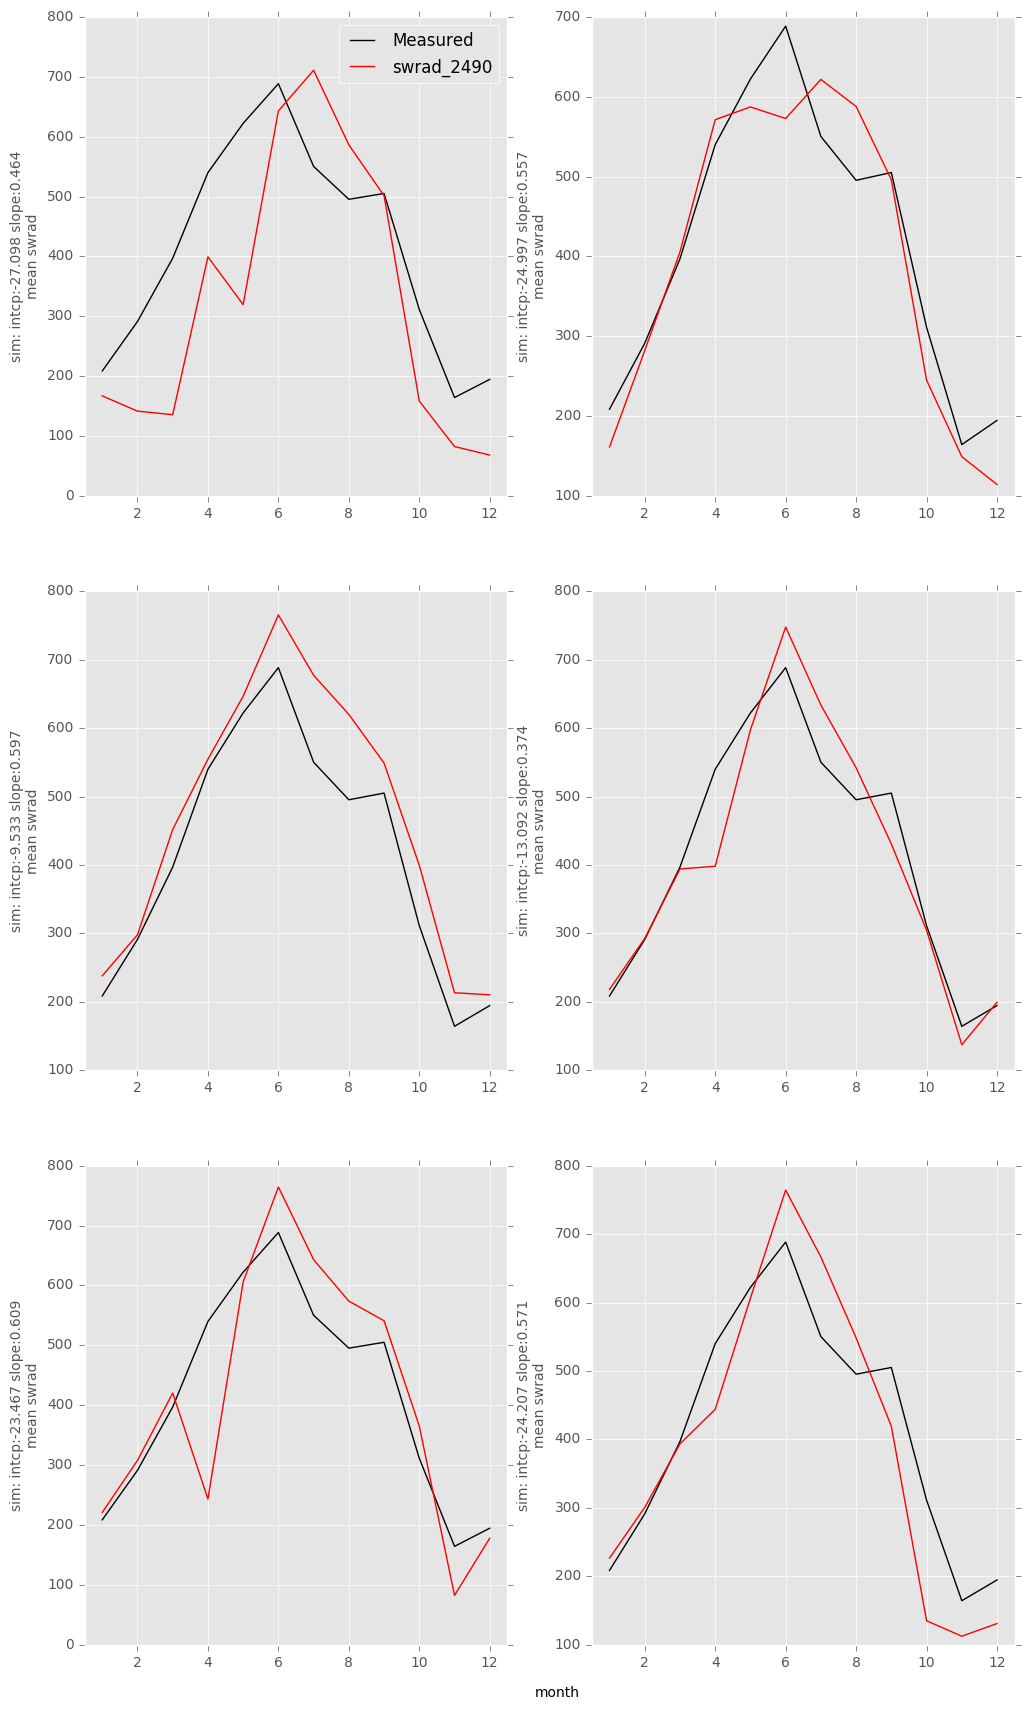

In [12]:
optr.plot_srad_optimization(freq='monthly', plot_vars='meas')